In [119]:
import quantstats as qs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from datetime import datetime
from bs4 import BeautifulSoup


# this will be an analysis of the FRC stock, First Republic Bank.

ticker = 'FRC'

                           Strategy
-------------------------  ----------
Start Period               2010-12-09
End Period                 2023-04-28
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -86.28%
CAGR﹪                     -14.81%

Sharpe                     -0.06
Prob. Sharpe Ratio         41.31%
Smart Sharpe               -0.05
Sortino                    -0.07
Smart Sortino              -0.06
Sortino/√2                 -0.05
Smart Sortino/√2           -0.05
Omega                      0.98

Max Drawdown               -98.4%
Longest DD Days            527
Volatility (ann.)          45.86%
Calmar                     -0.15
Skew                       -7.65
Kurtosis                   149.71

Expected Daily %           -0.06%
Expected Monthly %         -1.32%
Expected Yearly %          -13.23%
Kelly Criterion            -0.85%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.76%
Expected Shortfall (cVaR)  -4.76%

Max Consec

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-17,2023-04-28,2023-04-28,527,-98.403812,-94.461092
2,2020-01-15,2020-03-23,2020-10-07,266,-37.286421,-32.483370
3,2011-05-31,2011-10-03,2012-09-21,479,-35.028923,-31.849702
4,2018-08-22,2018-12-24,2019-04-23,244,-24.299302,-23.129327
5,2017-10-04,2018-01-02,2018-08-17,317,-19.078469,-17.478331


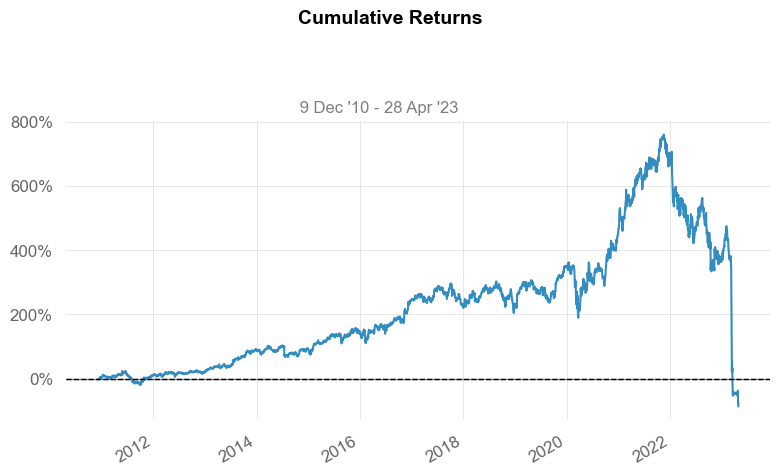

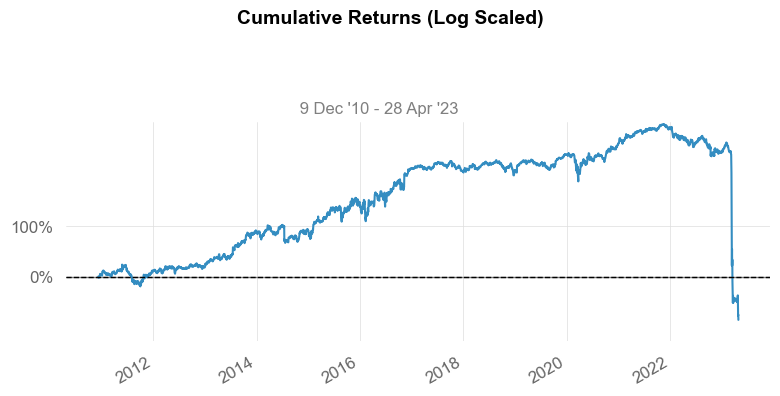

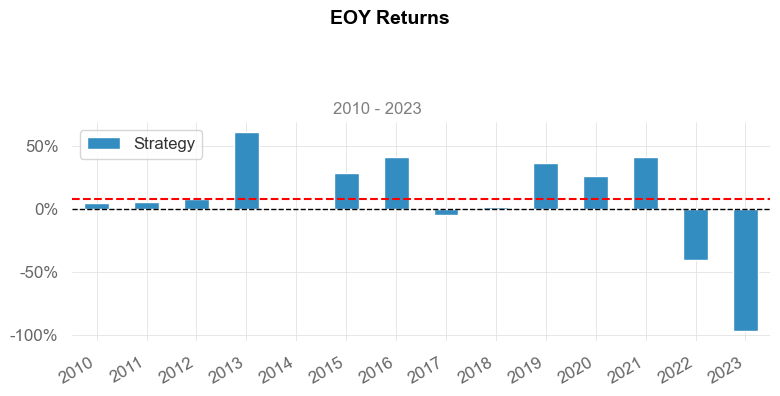

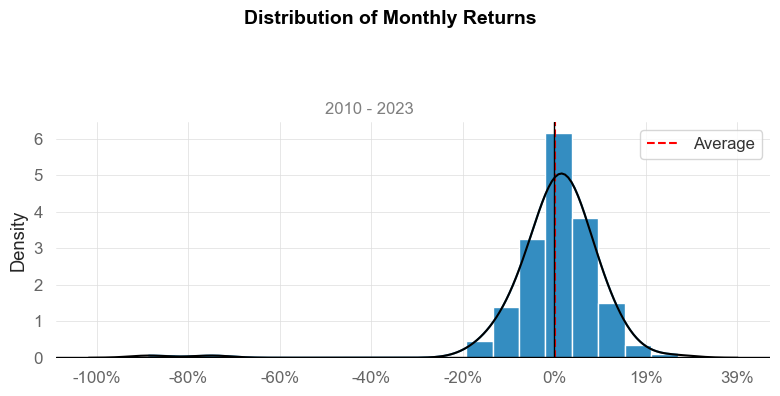

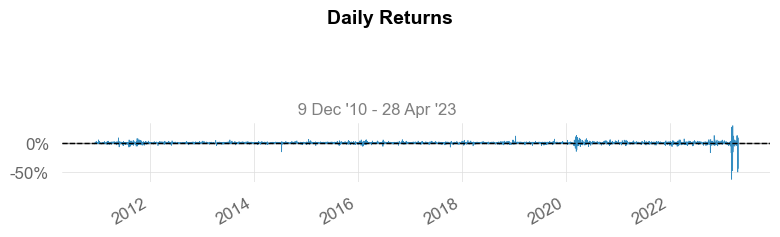

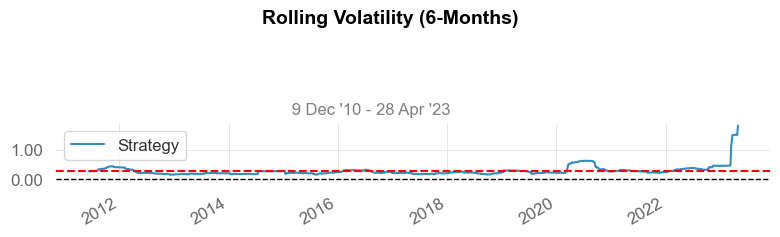

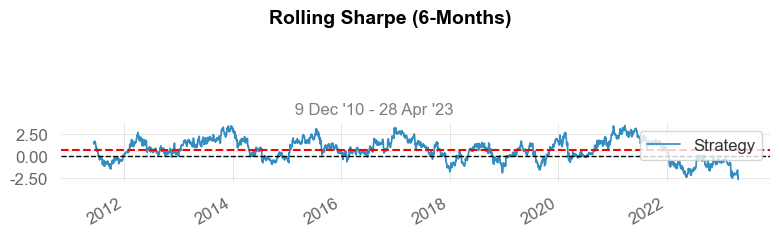

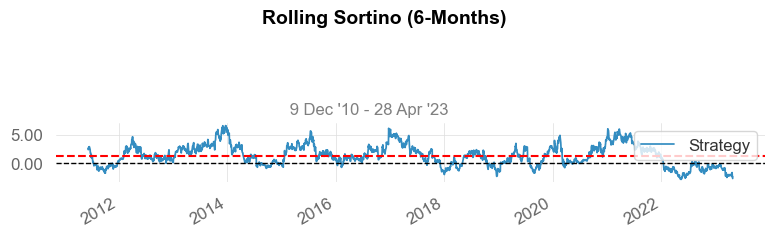

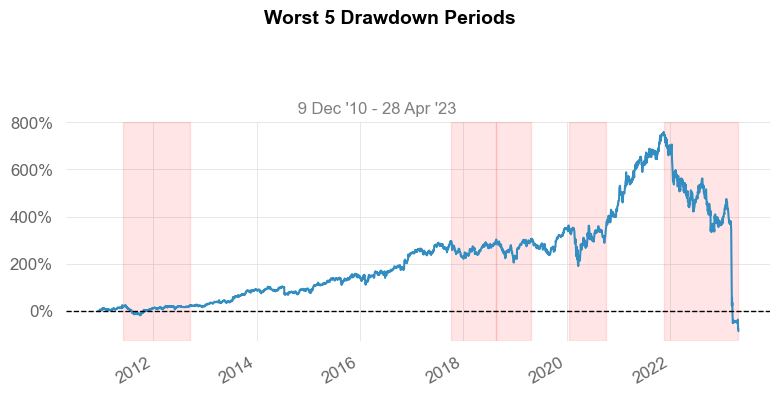

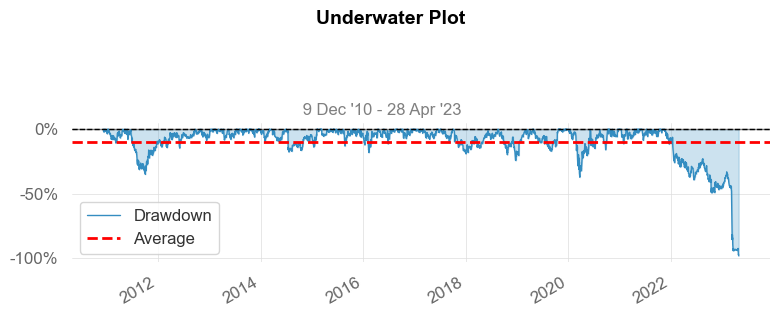

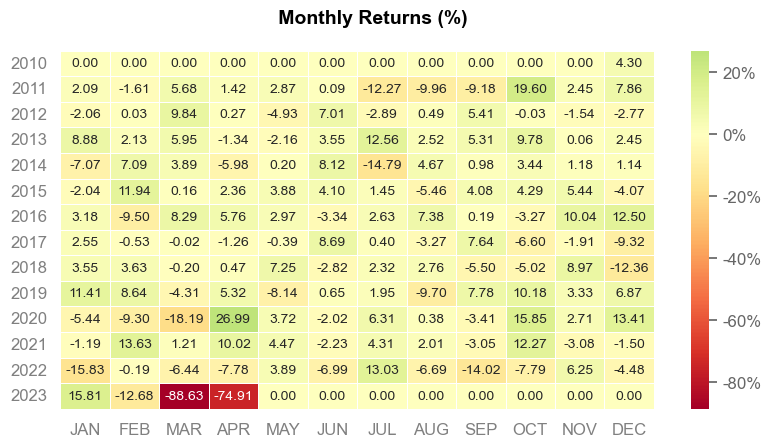

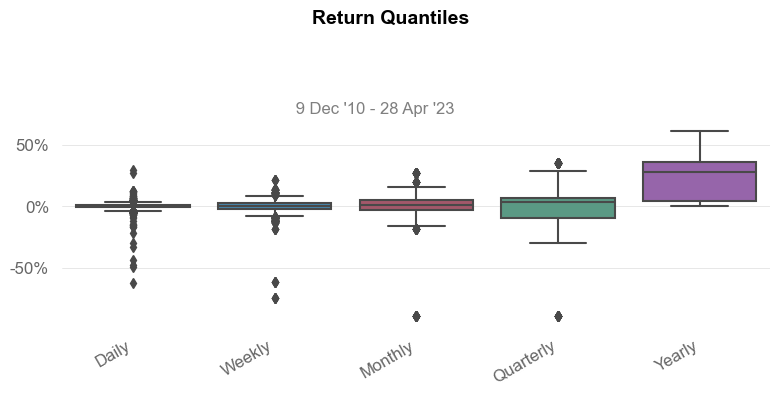

In [120]:
frc = qs.utils.download_returns(ticker)
qs.reports.full(frc.tz_localize(None,ambiguous='infer'))

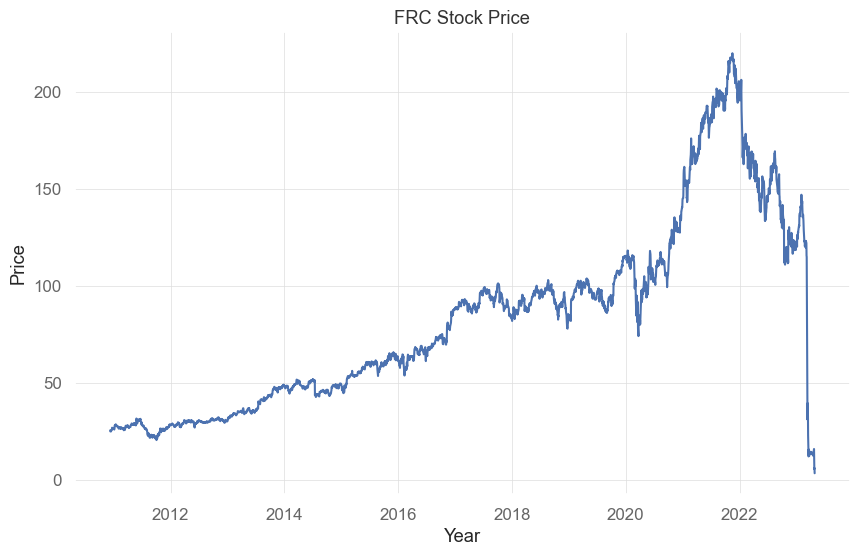

                 Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2010-12-09  24.966265  25.754192  24.728054  25.580114  10609700        0.0   
2010-12-10  25.103690  25.396871  24.792184  25.112852   1206800        0.0   
2010-12-13  25.195317  25.396878  24.737220  25.103697    473200        0.0   
2010-12-14  25.378551  25.625922  24.755539  25.021235    358200        0.0   
2010-12-15  24.920459  25.378556  24.911297  25.149508    242200        0.0   

            Stock Splits  MA20  MA50       ATR   Returns  
Date                                                      
2010-12-09             0   NaN   NaN  1.026137       NaN  
2010-12-10             0   NaN   NaN  0.604687 -0.018436  
2010-12-13             0   NaN   NaN  0.659659 -0.000365  
2010-12-14             0   NaN   NaN  0.870382 -0.003290  
2010-12-15             0   NaN   NaN  0.467259  0.005113  


In [121]:

# Fetch FRC's historical stock data
stock_data = yf.Ticker(ticker).history(period="max")

# Clean the data
stock_data = stock_data.dropna()

# Plot the stock price
plt.plot(stock_data['Close'])
plt.title(f"{ticker} Stock Price")
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

# Calculate financial indicators
stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['ATR'] = stock_data['High'] - stock_data['Low']
stock_data['Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

# Print the data
print(stock_data.head())

In [128]:
# this snippet from this link: https://stackoverflow.com/questions/70090315/balance-sheet-from-using-yfinance-does-not-have-total-debt-like-on-yahoo-finan

url = "https://finance.yahoo.com/quote/FRC/balance-sheet?p=FRC"
header = {'Connection': 'keep-alive',
            'Expires': '-1',
            'Upgrade-Insecure-Requests': '1',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
            AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
            }
    
r = requests.get(url, headers=header)
html = r.text
soup = BeautifulSoup(html, "html.parser")

div = soup.find_all('div', attrs={'class': 'D(tbhg)'})
if len(div) < 1:
    print("Fail to retrieve table column header")
    exit(0)

col = []
for h in div[0].find_all('span'):
    text = h.get_text()
    if text != "Breakdown":
        col.append( datetime.strptime(text, "%m/%d/%Y") )
        

dfs = []
for div in soup.find_all('div', attrs={'data-test': 'fin-row'}):
    i = 0
    idx = ""
    val = []
    for h in div.find_all('span'):
        if i == 0:
            idx = h.get_text()
        else:
            num = int(h.get_text().replace(",", "")) * 1000
            val.append( num )
        i += 1
    row = pd.DataFrame([val], columns=col[0:len(val)], index=[idx])

    dfs.append(row)

balance_sheet = pd.concat(dfs)


# all numbers are in thousands, so we need to multiply by 1000 to get the actual number

In [129]:
balance_sheet.to_csv('balance_sheet.csv')

# compare 2019-12-31 with 2022-12-31

bs = balance_sheet['2022-12-31']- balance_sheet['2019-12-31'] 

# print(bs)

print(bs)

# what's the % change of assets vs debt between 2022 and 2019 

percent_asset_change = balance_sheet['2022-12-31']['Total Assets']/balance_sheet['2019-12-31']['Total Assets']

percent_debt_change = balance_sheet['2022-12-31']['Total Debt']/balance_sheet['2019-12-31']['Total Debt']


print("\nAsset to debt ratio change between 2019 and 2022")
print(percent_asset_change/percent_debt_change)
# we see that the asset to debt ratio is > 1 which is good.

Total Assets                               9.637537e+10
Total Liabilities Net Minority Interest    8.878047e+10
Total Equity Gross Minority Interest       7.594893e+09
Total Capitalization                       2.698289e+09
Preferred Stock Equity                     2.488000e+09
Common Stock Equity                        5.106893e+09
Capital Lease Obligations                           NaN
Net Tangible Assets                        7.642882e+09
Invested Capital                           6.560289e+09
Tangible Book Value                        5.154882e+09
Total Debt                                 6.418550e+08
Net Debt                                            NaN
Share Issued                               1.462900e+07
Ordinary Shares Number                     1.462900e+07
Preferred Shares Number                    9.950000e+07
dtype: float64

Asset to debt ratio change between 2019 and 2022
1.7521063840188038


# Here are some key takeaways from the data: 

The company's cumulative return over the period was -86.28%, indicating that investors who held onto the company's stock during this time would have lost a significant amount of money.

The CAGR (Compound Annual Growth Rate) was -14.81%, which is the average annual rate of return over the period. This is a negative rate, indicating that the company's stock lost value over the period.

The Sharpe ratio is negative, indicating that the company's returns did not compensate for the level of risk taken. The Smart Sharpe and Sortino ratios are also negative, indicating poor risk-adjusted performance.

The company had a high maximum drawdown of 98.4%, meaning that at its worst point during the period, the stock had lost almost all of its value.

The report also includes various financial metrics for the company, such as total assets, total debt, and share issued.Based on the provided financial metrics for the years 2019-2022, the company has a total asset value of 96.38 billion USD. The total liabilities net minority interest is 87.88 billion USD, while the total equity gross minority interest is 7.59 billion USD. The company's total capitalization is 2.70 billion USD, of which 2.49 billion USD is preferred stock equity and 5.11 billion USD is common stock equity. The company has a net tangible asset value of 7.64 billion USD, invested capital of 6.56 billion USD, and tangible book value of 5.15 billion USD. The company has a total debt of 641.86 million USD, and net debt information is not available. The company has issued 14.63 million shares of both ordinary and preferred shares.

Overall, the financial metrics indicate that the company has a significant amount of assets and a considerable amount of debt, this report paints a negative picture of the company's performance over the period, with poor returns, high risk, and extreme losses.
